# Imports

In [ ]:
!pip install datasets transformers peft bitsandbytes accelerate
!pip install evaluate
!pip install rouge_score
!pip install unsloth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import torch
from torch.utils.data import DataLoader
from datasets import load_dataset, concatenate_datasets
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig,
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from unsloth import FastLanguageModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import evaluate
import time

<ipython-input-4-d1aed65c37aa>:15: UserWarning: WARNING: Unsloth should be imported before transformers, peft to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel  # Add this line


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
dataset_name = "ibm-research/duorc"

selfrc = load_dataset(dataset_name, "SelfRC")

def sample_and_combine(split, sample_size, seed=42):
    ds_self = selfrc[split].shuffle(seed=seed).select(range(sample_size))
    return ds_self

#dataset = load_dataset(dataset_name, subset_name)

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.9M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/3.11M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/3.04M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60721 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/12961 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12559 [00:00<?, ? examples/s]

In [ ]:
def format_qa_example(example):
    plot = example["plot"]
    title = example["title"]
    question = example["question"]
    answers_list = example["answers"]
    answer = answers_list[0] if answers_list else "I'm sorry, but the plot does not provide an answer."

    prompt = f'''
    In the movie "{title}"
    The plot was as follows: {plot}
    Question: {question}
    Answer (in a concise phrase):
    '''.strip()

    return {
        "prompt": prompt,
        "target": answer,
    }


In [ ]:
def count_words(text):
    return len(text.split())

def remove_long_samples(dataset, threshold):
    return dataset.filter(lambda x: count_words(x["prompt"] + " " + x["target"]) <= threshold)


In [ ]:
train_data = sample_and_combine("train", 50) # 12500
train_data = train_data.map(format_qa_example)

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [ ]:
train_data.select(range(5)).to_pandas()

,plot_id,plot,title,question_id,question,answers,no_answer,prompt,target
0,/m/06gb1w,"Twenty years ago, Professor Charles Xavier and...",X-Men: The Last Stand,da1ec953-74ae-8c64-86ac-f97a33713ba9,Where is Jean Grey twenty years ago?,[her parents' house],False,"In the movie ""X-Men: The Last Stand""\n The ...",her parents' house
1,/m/0gfgpw7,While working with the UN Forces in the Democr...,Sniper: Reloaded,011c3673-57c1-59e5-20a2-27ec58dc1b37,What profession does Billy Zane play in the film?,[Sniper instructor],False,"In the movie ""Sniper: Reloaded""\n The plot ...",Sniper instructor
2,/m/04mz27h,"During the rage of Hurricane Katrina, Detectiv...",Streets of Blood,afa84e87-1c15-82f8-75fc-20e376ab9f4b,What is the name of the newly transferred dete...,[Stan Johnson],False,"In the movie ""Streets of Blood""\n The plot ...",Stan Johnson
3,/m/02q2wnw,This article's plot summary may be too long or...,Lakeview Terrace,0acfc466-650c-1844-def2-a4989162cdbb,Why are the residents evacuating their homes?,[wildfires],False,"In the movie ""Lakeview Terrace""\n The plot ...",wildfires
4,/m/0f7djb,"A Belgian criminal, wanted all over Europe for...",Taxi 4,55e1efbc-7ed4-56b1-73f6-3a6e0d154ab0,Why does Emillen seek the criminal?,[To get his job back.],False,"In the movie ""Taxi 4""\n The plot was as fol...",To get his job back.


# Data preparation


In [ ]:
print(selfrc)

DatasetDict({
    train: Dataset({
        features: ['plot_id', 'plot', 'title', 'question_id', 'question', 'answers', 'no_answer'],
        num_rows: 60721
    })
    validation: Dataset({
        features: ['plot_id', 'plot', 'title', 'question_id', 'question', 'answers', 'no_answer'],
        num_rows: 12961
    })
    test: Dataset({
        features: ['plot_id', 'plot', 'title', 'question_id', 'question', 'answers', 'no_answer'],
        num_rows: 12559
    })
})


In [ ]:
'''
train_dataset = dataset["train"].shuffle(seed=42).select(range(int(0.05 * len(dataset["train"]))))
val_dataset   = dataset["validation"].shuffle(seed=42).select(range(int(0.05 * len(dataset["validation"]))))
test_dataset  = dataset["test"].shuffle(seed=42).select(range(int(0.05 * len(dataset["test"]))))


train_data = dataset["train"].shuffle(seed=42).select(range(100))
val_data   = dataset["validation"].shuffle(seed=42).select(range(100))
test_data  = dataset["test"].shuffle(seed=42).select(range(100))
'''

train_data = sample_and_combine("train", 25000) # 12500
val_data   = sample_and_combine("validation", 2000) # 1250
test_data  = sample_and_combine("test", 2000) # 12500

In [ ]:
print(train_data)
print(val_data)
print(test_data)

Dataset({
    features: ['plot_id', 'plot', 'title', 'question_id', 'question', 'answers', 'no_answer'],
    num_rows: 25000
})
Dataset({
    features: ['plot_id', 'plot', 'title', 'question_id', 'question', 'answers', 'no_answer'],
    num_rows: 2000
})
Dataset({
    features: ['plot_id', 'plot', 'title', 'question_id', 'question', 'answers', 'no_answer'],
    num_rows: 2000
})


In [ ]:
train_data.select(range(5)).to_pandas()

,plot_id,plot,title,question_id,question,answers,no_answer
0,/m/06gb1w,"Twenty years ago, Professor Charles Xavier and...",X-Men: The Last Stand,da1ec953-74ae-8c64-86ac-f97a33713ba9,Where is Jean Grey twenty years ago?,[her parents' house],False
1,/m/0gfgpw7,While working with the UN Forces in the Democr...,Sniper: Reloaded,011c3673-57c1-59e5-20a2-27ec58dc1b37,What profession does Billy Zane play in the film?,[Sniper instructor],False
2,/m/04mz27h,"During the rage of Hurricane Katrina, Detectiv...",Streets of Blood,afa84e87-1c15-82f8-75fc-20e376ab9f4b,What is the name of the newly transferred dete...,[Stan Johnson],False
3,/m/02q2wnw,This article's plot summary may be too long or...,Lakeview Terrace,0acfc466-650c-1844-def2-a4989162cdbb,Why are the residents evacuating their homes?,[wildfires],False
4,/m/0f7djb,"A Belgian criminal, wanted all over Europe for...",Taxi 4,55e1efbc-7ed4-56b1-73f6-3a6e0d154ab0,Why does Emillen seek the criminal?,[To get his job back.],False


In [ ]:
train_data = train_data.map(format_qa_example)
val_data   = val_data.map(format_qa_example)
test_data  = test_data.map(format_qa_example)


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
train_data.select(range(5)).to_pandas()

,plot_id,plot,title,question_id,question,answers,no_answer,prompt,target
0,/m/06gb1w,"Twenty years ago, Professor Charles Xavier and...",X-Men: The Last Stand,da1ec953-74ae-8c64-86ac-f97a33713ba9,Where is Jean Grey twenty years ago?,[her parents' house],False,"In the movie ""X-Men: The Last Stand""\n The ...",her parents' house
1,/m/0gfgpw7,While working with the UN Forces in the Democr...,Sniper: Reloaded,011c3673-57c1-59e5-20a2-27ec58dc1b37,What profession does Billy Zane play in the film?,[Sniper instructor],False,"In the movie ""Sniper: Reloaded""\n The plot ...",Sniper instructor
2,/m/04mz27h,"During the rage of Hurricane Katrina, Detectiv...",Streets of Blood,afa84e87-1c15-82f8-75fc-20e376ab9f4b,What is the name of the newly transferred dete...,[Stan Johnson],False,"In the movie ""Streets of Blood""\n The plot ...",Stan Johnson
3,/m/02q2wnw,This article's plot summary may be too long or...,Lakeview Terrace,0acfc466-650c-1844-def2-a4989162cdbb,Why are the residents evacuating their homes?,[wildfires],False,"In the movie ""Lakeview Terrace""\n The plot ...",wildfires
4,/m/0f7djb,"A Belgian criminal, wanted all over Europe for...",Taxi 4,55e1efbc-7ed4-56b1-73f6-3a6e0d154ab0,Why does Emillen seek the criminal?,[To get his job back.],False,"In the movie ""Taxi 4""\n The plot was as fol...",To get his job back.


In [ ]:
train_data.filter(lambda x: x["no_answer"] is True).to_pandas()

Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

,plot_id,plot,title,question_id,question,answers,no_answer,prompt,target
0,/m/0g2906,"Some Youngsters , a pack of Dogs, lots of bloo...",The Breed,1a2e3a69-bcc9-3ff1-c1e5-94535c9db959,Why did Sarah stay on the island?,[],True,"In the movie ""The Breed""\n The plot was as ...","I'm sorry, but the plot does not provide an an..."
1,/m/0c0jgy,Young Tony Thompson (Jonathan Lipnicki) moves ...,The Little Vampire,525d22b9-2398-0e8a-a9f8-83b85addd17d,What did Rudolph reveals?,[],True,"In the movie ""The Little Vampire""\n The plo...","I'm sorry, but the plot does not provide an an..."
2,/m/0bys_y,Roy Waller (Nicolas Cage) is a con artist resi...,Matchstick Men,7f5ca1f5-8157-ab23-5382-93cbfe4da74e,what did Roy Found out when he awakens?,[],True,"In the movie ""Matchstick Men""\n The plot wa...","I'm sorry, but the plot does not provide an an..."
3,/m/04z48q,A helicopter circles over the Panamanian jungl...,Basic,d39c2b35-f8f3-6313-ea71-e5170e765507,Why was the training mission set up ?,[],True,"In the movie ""Basic""\n The plot was as foll...","I'm sorry, but the plot does not provide an an..."
4,/m/0ggbhy7,"In October 1973, ""Control"", head of British in...","Tinker, Tailor, Soldier, Spy",74119cd1-87ef-83dd-e08f-eb628d8fafce,"Who chooses , Peter Guillam, to help him.",[],True,"In the movie ""Tinker, Tailor, Soldier, Spy""\n ...","I'm sorry, but the plot does not provide an an..."
...,...,...,...,...,...,...,...,...,...
252,/m/0frb0z,Dragon Tiger Gate is an academy established by...,Dragon Tiger Gate,9e984148-2a9a-be92-d05e-3a65644ef2f3,what turbo follows?,[],True,"In the movie ""Dragon Tiger Gate""\n The plot...","I'm sorry, but the plot does not provide an an..."
253,/m/02q5qx0,"Soong, a Khmer Rouge terrorist with plans to s...",Purple Storm,25ad0125-c1a0-4ae7-02e9-39c1c0d91520,How does Guan escape?,[],True,"In the movie ""Purple Storm""\n The plot was ...","I'm sorry, but the plot does not provide an an..."
254,/m/04dcpy,"In 1943, after their successful mission on the...",Force 10 from Navarone,8f9283e3-d97c-8f37-fa4f-087223509b19,where barnsby and crew escape,[],True,"In the movie ""Force 10 from Navarone""\n The...","I'm sorry, but the plot does not provide an an..."
255,/m/06zlvbc,This article's plot summary may be too long or...,Wrong Turn 3: Left for Dead,46923291-ce5b-f15c-ab00-9f1f33a8c592,what sheriff carver decides?,[],True,"In the movie ""Wrong Turn 3: Left for Dead""\n ...","I'm sorry, but the plot does not provide an an..."


In [ ]:
df = train_data.to_pandas()

top_movies = df['title'].value_counts().head(5)
print("Top 5 movies:")
print(top_movies)

Top 5 movies:
title
Nothing Like the Holidays    50
The Shrine                   41
The Three Musketeers         34
Election                     33
Arunachalam                  32
Name: count, dtype: int64


In [ ]:
#!huggingface-cli login

## Words distribution



Train Split:
Prompts - Mean: 960.4, Median: 745.0, Max: 11423
Combined - Mean: 963.0, Median: 747.0, Max: 11424


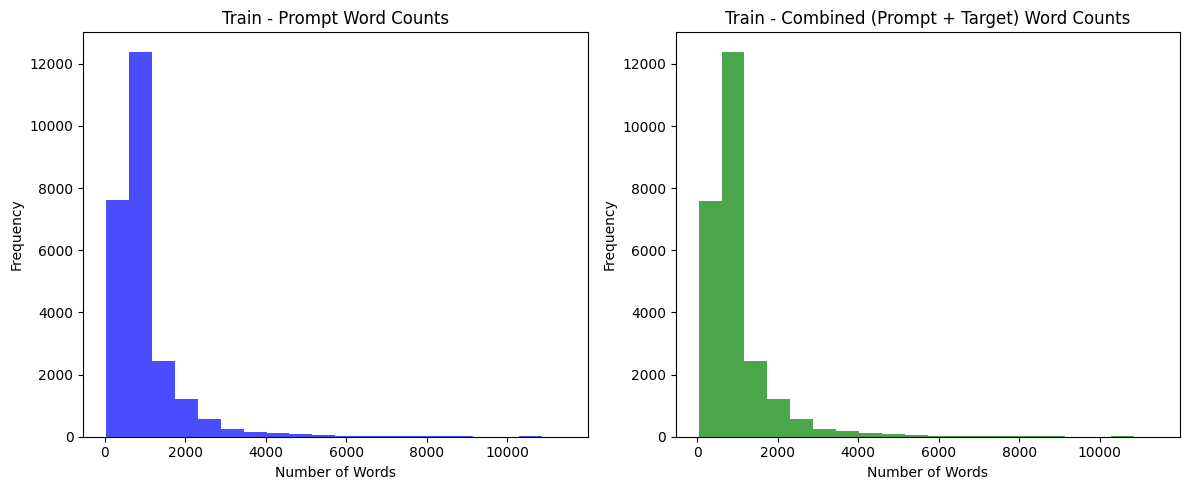


Validation Split:
Prompts - Mean: 913.1, Median: 753.0, Max: 7491
Combined - Mean: 915.6, Median: 756.0, Max: 7493


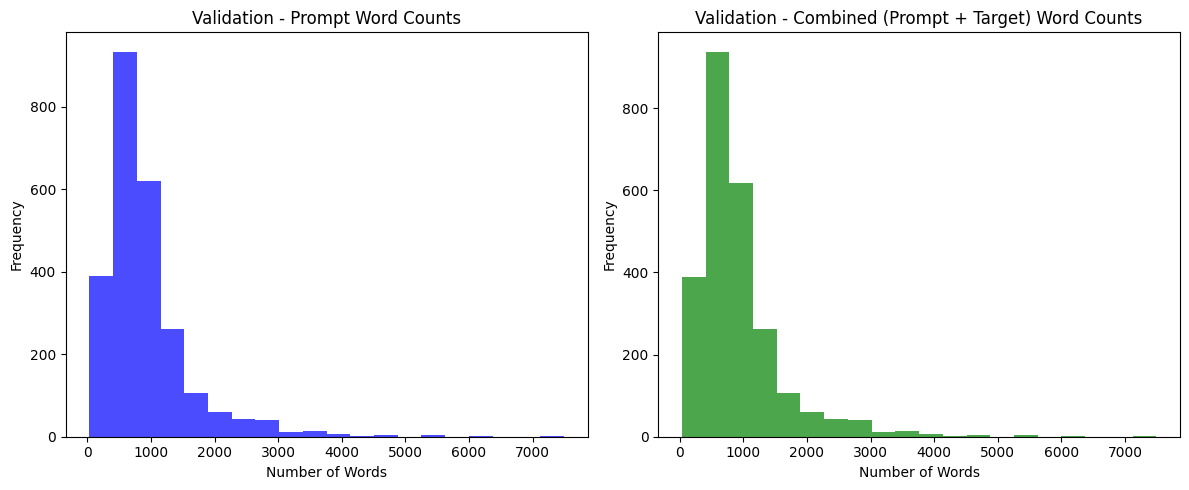


Test Split:
Prompts - Mean: 966.0, Median: 740.5, Max: 9302
Combined - Mean: 968.6, Median: 744.0, Max: 9304


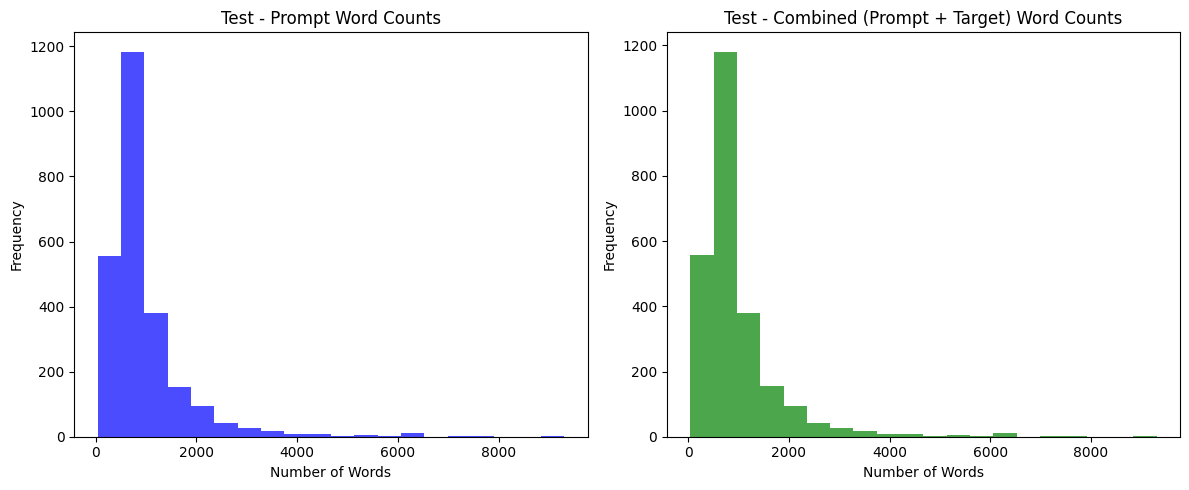

In [ ]:
def analyze_word_distribution(dataset, split_name):
    prompts = dataset["prompt"]
    targets = dataset["target"]
    prompt_word_counts = [count_words(p) for p in prompts]
    combined_word_counts = [count_words(f"{p} {t}") for p, t in zip(prompts, targets)]
    print(f"\n{split_name} Split:")
    print(f"Prompts - Mean: {np.mean(prompt_word_counts):.1f}, Median: {np.median(prompt_word_counts):.1f}, Max: {max(prompt_word_counts)}")
    print(f"Combined - Mean: {np.mean(combined_word_counts):.1f}, Median: {np.median(combined_word_counts):.1f}, Max: {max(combined_word_counts)}")
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(prompt_word_counts, bins=20, color='blue', alpha=0.7)
    plt.title(f"{split_name} - Prompt Word Counts")
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")
    plt.subplot(1, 2, 2)
    plt.hist(combined_word_counts, bins=20, color='green', alpha=0.7)
    plt.title(f"{split_name} - Combined (Prompt + Target) Word Counts")
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# Analyze each split (using the processed datasets)
analyze_word_distribution(train_data, "Train")
analyze_word_distribution(val_data, "Validation")
analyze_word_distribution(test_data, "Test")

## Remove long text

In [ ]:
def count_words(text):
    return len([word for word in text.split() if word])

In [ ]:
def print_exceeding_percentage_words(dataset, threshold):
    count_exceed = 0
    total = len(dataset)
    for example in dataset:
        full_text = example["prompt"] + " " + example["target"]
        if count_words(full_text) > threshold:
            count_exceed += 1
    percent = (count_exceed / total) * 100
    print(f"Percentage of samples exceeding {threshold} words: {percent:.2f}%")


In [ ]:
print_exceeding_percentage_words(train_data, threshold=1800)

In [ ]:
\train_data = remove_long_samples(train_data, threshold=1800)
val_data   = remove_long_samples(val_data, threshold=1800)
test_data  = remove_long_samples(test_data, threshold=1800)

print(f"After filtering, Train size: {len(train_data)}")
print(f"After filtering, Validation size: {len(val_data)}")
print(f"After filtering, Test size: {len(test_data)}")

Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

After filtering, Train size: 24792
After filtering, Validation size: 1985
After filtering, Test size: 1987


In [ ]:
train_data.select(range(5)).to_pandas()

,plot_id,plot,title,question_id,question,answers,no_answer,prompt,target
0,/m/06gb1w,"Twenty years ago, Professor Charles Xavier and...",X-Men: The Last Stand,da1ec953-74ae-8c64-86ac-f97a33713ba9,Where is Jean Grey twenty years ago?,[her parents' house],False,"In the movie ""X-Men: The Last Stand""\n The ...",her parents' house
1,/m/0gfgpw7,While working with the UN Forces in the Democr...,Sniper: Reloaded,011c3673-57c1-59e5-20a2-27ec58dc1b37,What profession does Billy Zane play in the film?,[Sniper instructor],False,"In the movie ""Sniper: Reloaded""\n The plot ...",Sniper instructor
2,/m/04mz27h,"During the rage of Hurricane Katrina, Detectiv...",Streets of Blood,afa84e87-1c15-82f8-75fc-20e376ab9f4b,What is the name of the newly transferred dete...,[Stan Johnson],False,"In the movie ""Streets of Blood""\n The plot ...",Stan Johnson
3,/m/02q2wnw,This article's plot summary may be too long or...,Lakeview Terrace,0acfc466-650c-1844-def2-a4989162cdbb,Why are the residents evacuating their homes?,[wildfires],False,"In the movie ""Lakeview Terrace""\n The plot ...",wildfires
4,/m/0f7djb,"A Belgian criminal, wanted all over Europe for...",Taxi 4,55e1efbc-7ed4-56b1-73f6-3a6e0d154ab0,Why does Emillen seek the criminal?,[To get his job back.],False,"In the movie ""Taxi 4""\n The plot was as fol...",To get his job back.


# Load Model and Tokenizer

In [ ]:
model_name = "unsloth/Qwen2.5-3B"
max_length = 2048

print("Loading model and tokenizer with Unsloth...")
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_name,
    max_seq_length=max_length,
    dtype=None,
    load_in_4bit=True,
)

Loading model and tokenizer with Unsloth...
==((====))==  Unsloth 2025.3.18: Fast Qwen2 patching. Transformers: 4.49.0.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.56G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `eager`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.71k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

print("Applying LoRA with Unsloth...")
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,  # LoRA rank
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha=32,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing = "unsloth",
    random_state=3407,
    use_rslora=True,

)

Applying LoRA with Unsloth...


Unsloth 2025.3.18 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.


# Tokenization

In [ ]:
from transformers import DataCollatorForLanguageModeling

max_length = 2048

def tokenize_function(ex, tokenizer, max_length=2048):

    title = ex.get("title", "")
    plot  = ex.get("plot", "")
    question = ex.get("question", "")
    answer   = ex.get("target", "")

    prefix = f'In the movie "{title}"\nThe plot was as follows: '
    question_part = f'\nQuestion: {question}\nAnswer (in a concise phrase): '

    prefix_tokens   = tokenizer.encode(prefix, add_special_tokens=False)
    plot_tokens     = tokenizer.encode(plot, add_special_tokens=False)
    question_tokens = tokenizer.encode(question_part, add_special_tokens=False)
    answer_tokens   = tokenizer.encode(answer, add_special_tokens=False)

    answer_tokens.append(tokenizer.eos_token_id)

    prefix_len   = len(prefix_tokens)
    plot_len     = len(plot_tokens)
    question_len = len(question_tokens)
    answer_len   = len(answer_tokens)

    reserved = prefix_len + question_len + answer_len
    allowed_plot_tokens = max_length - reserved

    plot_tokens = plot_tokens[:allowed_plot_tokens]
    plot_len = len(plot_tokens)

    input_ids = prefix_tokens + plot_tokens + question_tokens + answer_tokens
    input_ids = input_ids[:max_length]

    attention_mask = [1] * len(input_ids)
    padding_len = max_length - len(input_ids)
    if padding_len > 0:
        input_ids += [tokenizer.pad_token_id] * padding_len
        attention_mask += [0] * padding_len

    plot_start = prefix_len
    plot_end   = prefix_len + plot_len
    prompt_length = prefix_len + plot_len + question_len

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "prompt_length": prompt_length,
        "plot_start": plot_start,
        "plot_end": plot_end
    }

def tokenize_and_remove_cols(example):
    return tokenize_function(example, tokenizer, max_length=2048)


In [ ]:
train_dataset = train_data.map(
    tokenize_and_remove_cols,
    batched=False,
    remove_columns=train_data.column_names
)
val_dataset = val_data.map(
    tokenize_and_remove_cols,
    batched=False,
    remove_columns=val_data.column_names
)
test_dataset = test_data.map(
    tokenize_and_remove_cols,
    batched=False,
    remove_columns=test_data.column_names
)

Map:   0%|          | 0/24792 [00:00<?, ? examples/s]

Map:   0%|          | 0/1985 [00:00<?, ? examples/s]

Map:   0%|          | 0/1987 [00:00<?, ? examples/s]

In [ ]:
train_dataset.select(range(5)).to_pandas()

,input_ids,attention_mask,prompt_length,plot_start,plot_end
0,"[641, 279, 5700, 330, 55, 49459, 25, 576, 7996...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",987,18,968
1,"[641, 279, 5700, 330, 20720, 12858, 25, 56341,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",180,17,158
2,"[641, 279, 5700, 330, 623, 265, 1415, 315, 200...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",475,17,446
3,"[641, 279, 5700, 330, 81289, 1050, 79170, 698,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1294,15,1274
4,"[641, 279, 5700, 330, 31349, 72, 220, 19, 698,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",197,16,177


In [ ]:
row = train_dataset[0]

decoded_text = tokenizer.decode(row["input_ids"], skip_special_tokens=False)

print(f"=== Sample {0} ===")
print("Decoded text:")
print(decoded_text)


=== Sample 0 ===
Decoded text:
In the movie "X-Men: The Last Stand"
The plot was as follows: Twenty years ago, Professor Charles Xavier and Erik Lehnsherr meet young Jean Grey at her parents' house to invite her to join their school, the X-Mansion. Ten years later, the industrialist father of Warren Worthington III discovers his son is a mutant as Warren tries to cut off his wings.
In the present, Worthington Labs announces it has developed an inoculation to suppress the X-gene that gives mutants their abilities, and offer the "cure" to any mutant who wants it. The cure is created from the genome of a young mutant named Jimmy, who lives at the Worthington facility on Alcatraz Island. While some mutants are interested in the cure, including the X-Men's Rogue, many others are horrified by the announcement. Lehnsherr re-establishes his Brotherhood of Mutants with those who oppose the cure, warning his followers that the cure will be forcefully used to exterminate the mutant race.
With hel

In [ ]:
tokenizer.pad_token

'<|endoftext|>'

In [ ]:
tokenizer.eos_token

'<|endoftext|>'

# Data Collator


In [ ]:
import torch
import random

def custom_collate_fn(examples):
    batch = tokenizer.pad(
        {
            "input_ids": [ex["input_ids"] for ex in examples],
            "attention_mask": [ex["attention_mask"] for ex in examples]
        },
        padding=True,
        return_tensors="pt"
    )
    input_ids = batch["input_ids"]
    labels = input_ids.clone()
    labels[:] = -100

    for i, ex in enumerate(examples):
        prompt_len = ex["prompt_length"]
        plot_start = ex["plot_start"]
        plot_end   = ex["plot_end"]
        attn = batch["attention_mask"][i]
        seq_len = attn.sum().item()

        # (A) Label the final answer tokens:
        if prompt_len < seq_len:
            labels[i, prompt_len:seq_len] = input_ids[i, prompt_len:seq_len]

        # (B) Random 30% chunk from the plot region:
        actual_plot_end = min(plot_end, seq_len)
        if actual_plot_end > plot_start:
            plot_length = actual_plot_end - plot_start
            chunk_size = max(1, int(plot_length * 0.30))
            if chunk_size <= plot_length:
                import random
                chunk_start = random.randint(plot_start, actual_plot_end - chunk_size)
                chunk_end = chunk_start + chunk_size
                labels[i, chunk_start:chunk_end] = input_ids[i, chunk_start:chunk_end]

    batch["labels"] = labels
    return batch

# Replace the default data collator
data_collator = custom_collate_fn

In [ ]:
sample_ds = train_dataset.select(range(5))
batch = custom_collate_fn(sample_ds)

labels = batch["labels"]
input_ids = batch["input_ids"]
attn_mask = batch["attention_mask"]

for i in range(labels.shape[0]):
    print(f"--- Sample {i} ---")

    ex = sample_ds[i]
    prompt_len = ex["prompt_length"]
    plot_start = ex["plot_start"]
    plot_end   = ex["plot_end"]
    seq_len    = attn_mask[i].sum().item()

    labeled_positions = (labels[i] != -100).nonzero(as_tuple=True)[0].tolist()
    print(f"  labeled_positions= {labeled_positions}")
    print(f"  seq_len= {seq_len}, prompt_len= {prompt_len}, plot_start= {plot_start}, plot_end= {plot_end}")

    # If you want, decode the labeled tokens:
    # (They might be numerous, so maybe just do a small slice or check partial.)
    labeled_ids = [input_ids[i, j].item() for j in labeled_positions]
    decoded_str = tokenizer.decode(labeled_ids)
    print("  Decoded labeled tokens:", decoded_str[:200], "...")
    print()

--- Sample 0 ---
  labeled_positions= [76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 

# Training: SFT


In [ ]:
from transformers import TrainingArguments, Trainer
from unsloth import FastLanguageModel, is_bfloat16_supported

training_args = TrainingArguments(
    output_dir="finetuned-qwen2-3B-duorc",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    evaluation_strategy="steps",
    eval_steps=400,

    save_strategy="steps",
    save_steps=400,
    logging_steps=50,

    num_train_epochs=3,
    learning_rate=2e-4,

    bf16 = is_bfloat16_supported(),
    optim="adamw_8bit",
    weight_decay = 0.01,
    lr_scheduler_type = "linear",

    seed = 1234,
    report_to="wandb",
    remove_unused_columns=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=custom_collate_fn
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
#model = model.half()

In [ ]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 24,792 | Num Epochs = 3 | Total steps = 4,647
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 2 x 1) = 16
 "-____-"     Trainable parameters = 29,933,568/3,000,000,000 (1.00% trained)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: arisoy10 (arisoy) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
400,2.227700,2.538350
800,1.914400,2.647545
1200,1.635600,2.714561
1600,1.318900,2.927461
2000,1.183200,2.985677
2400,1.066700,3.056636
2800,0.977000,3.168490
3200,0.811800,3.282884
3600,0.716600,3.261071
4000,0.648900,3.452797


Unsloth: Not an error, but Qwen2ForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


TrainOutput(global_step=4647, training_loss=1.2382298886763143, metrics={'train_runtime': 24202.3624, 'train_samples_per_second': 3.073, 'train_steps_per_second': 0.192, 'total_flos': 2.561934015703548e+18, 'train_loss': 1.2382298886763143, 'epoch': 2.99838657631494})

In [ ]:
# Save adapters only
model.save_pretrained("finetuned-qwen2-3B-QA-adapters-2203")
tokenizer.save_pretrained("finetuned-qwen2-3B-QA-adapters")

# Save merged model separately
model.save_pretrained_merged("finetuned-qwen2-3B-QA-merged-2203", tokenizer, save_method="merged_16bit")

config.json:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 52.75 out of 83.48 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 36/36 [00:00<00:00, 118.97it/s]


Unsloth: Saving tokenizer... Done.
Done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

save_dir_adapters = "/content/drive/MyDrive/projet_IA/finetuned-qwen2-3B-QA-adapters-2203"
save_dir_tokenizer = "/content/drive/MyDrive/projet_IA/finetuned-qwen2-3B-QA-adapters"
save_dir_merged = "/content/drive/MyDrive/projet_IA/finetuned-qwen2-3B-QA-merged-2203"

model.save_pretrained(save_dir_adapters)
tokenizer.save_pretrained(save_dir_tokenizer)

# Save merged model separately (for example, in 16-bit format)
model.save_pretrained_merged(save_dir_merged, tokenizer, save_method="merged_16bit")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


config.json:   0%|          | 0.00/1.49k [00:00<?, ?B/s]

Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 52.71 out of 83.48 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 36/36 [00:00<00:00, 123.52it/s]


Unsloth: Saving tokenizer... Done.
Done.


# Inference


In [ ]:
drive.mount('/content/drive')

model_path = "/content/drive/MyDrive/projet_IA/finetuned-qwen2-3B-QA-merged-2203"

Mounted at /content/drive


In [ ]:
max_length = 2048

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_path,
    max_seq_length=max_length,
    dtype=None,
    load_in_4bit=True,
)
tokenizer.padding_side = "left"
model = FastLanguageModel.for_inference(model)

==((====))==  Unsloth 2025.3.18: Fast Qwen2 patching. Transformers: 4.49.0.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Sliding Window Attention is enabled but not implemented for `eager`; unexpected results may be encountered.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/content/drive/MyDrive/projet_IA/finetuned-qwen2-3B-QA-merged-2203 does not have a padding token! Will use pad_token = <|vision_pad|>.


In [ ]:
inference_set = sample_and_combine("validation", 8000)

inference_set = inference_set.map(format_qa_example)

inference_set   = remove_long_samples(inference_set, threshold=1800)
print(f"After filtering, Validation size: {len(inference_set)}")

In [ ]:
def tokenize_function_inference(ex, tokenizer, max_length=2048):
    """
    Tokenize the example for inference without including the original answer tokens.
    """
    # Extract fields (with default empty string if missing)
    title = ex.get("title", "")
    plot  = ex.get("plot", "")
    question = ex.get("question", "")

    # Build the prompt parts (no answer is included)
    prefix = f'In the movie "{title}"\nThe plot was as follows: '
    question_part = f'\nQuestion: {question}\nAnswer (in a concise phrase): '

    # Tokenize each segment (without adding special tokens)
    prefix_tokens   = tokenizer.encode(prefix, add_special_tokens=False)
    plot_tokens     = tokenizer.encode(plot, add_special_tokens=False)
    question_tokens = tokenizer.encode(question_part, add_special_tokens=False)

    # Compute lengths of each part
    prefix_len   = len(prefix_tokens)
    plot_len     = len(plot_tokens)
    question_len = len(question_tokens)

    # Since we are not including the answer tokens during inference,
    # the reserved space is just for prefix and question.
    reserved = prefix_len + question_len
    allowed_plot_tokens = max_length - reserved
    if allowed_plot_tokens < 0:
        raise ValueError(f"Fixed parts exceed max_length for example: {ex}")

    # Truncate the plot tokens if needed.
    plot_tokens = plot_tokens[:allowed_plot_tokens]
    plot_len = len(plot_tokens)

    # Concatenate only the prompt parts (without the answer)
    input_ids = prefix_tokens + plot_tokens + question_tokens
    input_ids = input_ids[:max_length]  # Safety truncate if needed

    # Create an attention mask for non-padded tokens
    attention_mask = [1] * len(input_ids)
    padding_len = max_length - len(input_ids)
    if padding_len > 0:
        # Left padding: add pad tokens to the beginning of the sequence
        input_ids = [tokenizer.pad_token_id] * padding_len + input_ids
        attention_mask = [0] * padding_len + attention_mask

    # Adjust boundaries (if needed for slicing outputs)
    plot_start = prefix_len + padding_len
    plot_end   = plot_start + plot_len
    prompt_length = prefix_len + plot_len + question_len + padding_len

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "prompt_length": prompt_length,
        "plot_start": plot_start,
        "plot_end": plot_end
    }

In [ ]:
inference_dataset = inference_set.map(
    lambda ex: tokenize_function_inference(ex, tokenizer, max_length),
    batched=False,
    remove_columns=[col for col in inference_set.column_names if col not in ["prompt", "answers", "plot_id", "question_id"]]
)

In [ ]:
def collate_fn(batch):
    input_ids = torch.tensor([item["input_ids"] for item in batch])
    attention_mask = torch.tensor([item["attention_mask"] for item in batch])

    # metadata
    prompts = [item["prompt"] for item in batch]
    prompt_lengths = [item["prompt_length"] for item in batch]
    plot_ids = [item["plot_id"] for item in batch]
    question_ids = [item["question_id"] for item in batch]
    answers = [item["answers"] for item in batch]

    return {
      "input_ids": input_ids,
      "attention_mask": attention_mask,
      "prompt": prompts,
      "answers": answers,
      "prompt_length": prompt_lengths,
      "plot_id": plot_ids,
      "question_id": question_ids,
    }

batch_size = 32 #32
dataloader = DataLoader(inference_dataset, batch_size=batch_size, collate_fn=collate_fn)

In [ ]:
model.eval()
model = FastLanguageModel.for_inference(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(next(iter(dataloader))["input_ids"].device)
print(model.device)  # Should also indicate a GPU device, e.g., cuda:0

cpu
cuda:0


In [ ]:
dataloader = DataLoader(
    inference_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=4,    # Adjust based on your CPU cores
    pin_memory=True
)

model = torch.compile(model)

In [ ]:
all_prompts = []
all_full_outputs = []
all_answers = []

results = []

with torch.no_grad():
    for batch in dataloader:
        # Move batch tensors to GPU
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)

        # Generate
        generated_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=32,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False,
            temperature=0.6,
            top_k=30,
            top_p=0.95,
            min_p=0,
            repetition_penalty=1.0,
        )

        # Process each example in the batch
        for i, gen_ids in enumerate(generated_ids):
            p_len = batch["prompt_length"][i]
            # Decode the full sequence (prompt + answer) if desired
            full_decoded = tokenizer.decode(gen_ids, skip_special_tokens=True)

            # Slice out just the answer
            answer_decoded = tokenizer.decode(gen_ids[p_len:], skip_special_tokens=True).strip()

            # Store relevant fields
            results.append({
                "plot_id": batch["plot_id"][i],
                "question_id": batch["question_id"][i],
                "prompt": batch["prompt"][i],
                "generated_answer": answer_decoded,
                "original_answers": batch["answers"][i],
                "encoded_prompmt": batch["input_ids"][i],
                "encoded_answer": gen_ids[p_len:],
            })


results_dataset = Dataset.from_list(results)
results_dataset.save_to_disk("my_inference_predictions")

Saving the dataset (0/1 shards):   0%|          | 0/7950 [00:00<?, ? examples/s]

In [ ]:
results_dataset = Dataset.from_list(results)
results_dataset.select(range(16)).to_pandas()

,plot_id,question_id,prompt,generated_answer,original_answers,encoded_prompmt,encoded_answer
0,/m/06rq_4,12c3e2f2-9673-a53f-6395-5a037317c505,"In the movie ""The Far Country""\n The plot w...",Dawes,[Dawson City],"[151654, 151654, 151654, 151654, 151654, 15165...","[35, 672, 288, 151643, 151643, 151643, 151643,..."
1,/m/0k3y_,ac28a48a-df41-97ac-db00-979920f4bb9b,"In the movie ""Red River""\n The plot was as ...",Texas,[Texas],"[151654, 151654, 151654, 151654, 151654, 15165...","[50225, 151643, 151643, 151643, 151643, 151643..."
2,/m/0bv6qnt,5a22ad5a-641d-e20f-5f27-85817746d2e0,"In the movie ""Paranormal Activity 2""\n The ...",Katie,[Katie],"[151654, 151654, 151654, 151654, 151654, 15165...","[42, 25852, 151643, 151643, 151643, 151643, 15..."
3,/m/02rntss,9425f7f9-28e3-e231-3662-d6d99baf1204,"In the movie ""Contraband""\n The plot was as...",He is shot by the police. He is then arrested ...,[They let him go],"[151654, 151654, 151654, 151654, 151654, 15165...","[1519, 374, 6552, 553, 279, 4282, 13, 1260, 37..."
4,/m/0gtbg7x,a15ec650-9699-db39-cb26-8cde24025037,"In the movie ""Arbitrage""\n The plot was as ...",His wife,[His wife],"[151654, 151654, 151654, 151654, 151654, 15165...","[15986, 7403, 151643, 151643, 151643, 151643, ..."
5,/m/01xbwj,2c956aea-99e8-d2d9-2e0a-8d53df5ac54c,"In the movie ""Attack of the 50 Foot Woman""\n ...",Honey,[HONEY PARKER],"[151654, 151654, 151654, 151654, 151654, 15165...","[39, 2534, 151643, 151643, 151643, 151643, 151..."
6,/m/03h0zx8,bb1aa8fc-9c58-14bb-40b1-865d516def89,"In the movie ""Daisy Town""\n The plot was as...",4,[four],"[151654, 151654, 151654, 151654, 151654, 15165...","[19, 151643, 151643, 151643, 151643, 151643, 1..."
7,/m/031gql,2c9e7d41-721d-ce30-d474-d42e829384ff,"In the movie ""Suburbia""\n The plot was as f...",Eating and Topping and walking car,[Joe Schmo],"[151654, 151654, 151654, 151654, 151654, 15165...","[36, 1095, 323, 350, 7008, 323, 11435, 1803, 1..."
8,/m/02x48b,9477197b-ce05-76a8-44c6-b5babab951e2,"In the movie ""Rasen""\n The plot was as foll...",Sadako,[Sadako],"[151654, 151654, 151654, 151654, 151654, 15165...","[59665, 28786, 151643, 151643, 151643, 151643,..."
9,/m/087w6_,93803a9a-6f0e-f67d-81f1-9a68c4d93d12,"In the movie ""Johnny Tsunami""\n The plot wa...",Hawaii,[Hawaii],"[151654, 151654, 151654, 151654, 151654, 15165...","[39, 70954, 151643, 151643, 151643, 151643, 15..."


In [ ]:
save_dir = "/content/drive/MyDrive/projet_IA/qwen-3B-inference-set"

results_dataset.save_to_disk(save_dir)

Saving the dataset (0/1 shards):   0%|          | 0/7950 [00:00<?, ? examples/s]

# Evaluation

In [ ]:
drive.mount('/content/drive')

model_path = "/content/drive/MyDrive/projet_IA/finetuned-qwen2-3B-QA-merged-2203"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
max_length = 2048

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_path,
    max_seq_length=max_length,
    dtype=None,
    load_in_4bit=True,
)
tokenizer.padding_side = "left"
model = FastLanguageModel.for_inference(model)

==((====))==  Unsloth 2025.3.18: Fast Qwen2 patching. Transformers: 4.49.0.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/content/drive/MyDrive/projet_IA/finetuned-qwen2-3B-QA-merged-2203 does not have a padding token! Will use pad_token = <|vision_pad|>.


In [ ]:
test_data = sample_and_combine("test", 2000)

test_data = test_data.map(format_qa_example)

test_data   = remove_long_samples(test_data, threshold=1800)
print(f"After filtering, test size: {len(test_data)}")

After filtering, test size: 1987


In [ ]:
def tokenize_function_inference(ex, tokenizer, max_length=2048):
    """
    Tokenize the example for inference without including the original answer tokens.
    """
    # Extract fields (with default empty string if missing)
    title = ex.get("title", "")
    plot  = ex.get("plot", "")
    question = ex.get("question", "")

    # Build the prompt parts (no answer is included)
    prefix = f'In the movie "{title}"\nThe plot was as follows: '
    question_part = f'\nQuestion: {question}\nAnswer (in a concise phrase): '

    # Tokenize each segment (without adding special tokens)
    prefix_tokens   = tokenizer.encode(prefix, add_special_tokens=False)
    plot_tokens     = tokenizer.encode(plot, add_special_tokens=False)
    question_tokens = tokenizer.encode(question_part, add_special_tokens=False)

    # Compute lengths of each part
    prefix_len   = len(prefix_tokens)
    plot_len     = len(plot_tokens)
    question_len = len(question_tokens)

    # Since we are not including the answer tokens during inference,
    # the reserved space is just for prefix and question.
    reserved = prefix_len + question_len
    allowed_plot_tokens = max_length - reserved
    if allowed_plot_tokens < 0:
        raise ValueError(f"Fixed parts exceed max_length for example: {ex}")

    # Truncate the plot tokens if needed.
    plot_tokens = plot_tokens[:allowed_plot_tokens]
    plot_len = len(plot_tokens)

    # Concatenate only the prompt parts (without the answer)
    input_ids = prefix_tokens + plot_tokens + question_tokens
    input_ids = input_ids[:max_length]  # Safety truncate if needed

    # Create an attention mask for non-padded tokens
    attention_mask = [1] * len(input_ids)
    padding_len = max_length - len(input_ids)
    if padding_len > 0:
        # Left padding: add pad tokens to the beginning of the sequence
        input_ids = [tokenizer.pad_token_id] * padding_len + input_ids
        attention_mask = [0] * padding_len + attention_mask

    # Adjust boundaries (if needed for slicing outputs)
    plot_start = prefix_len + padding_len
    plot_end   = plot_start + plot_len
    prompt_length = prefix_len + plot_len + question_len + padding_len

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "prompt_length": prompt_length,
        "plot_start": plot_start,
        "plot_end": plot_end
    }

In [ ]:
test_data = test_data.map(
    lambda ex: tokenize_function_inference(ex, tokenizer, max_length),
    batched=False,
    remove_columns=[col for col in test_data.column_names if col not in ["prompt", "answers", "plot_id", "question_id"]]
)

Map:   0%|          | 0/1987 [00:00<?, ? examples/s]

NameError: name 'tokenizer' is not defined

In [ ]:
test_data.select(range(5)).to_pandas()

,plot_id,question_id,answers,prompt,input_ids,attention_mask,prompt_length,plot_start,plot_end
0,/m/06r6nf,5d9fff6a-0507-fba1-b41c-21d7ad650f9a,[Adam],"In the movie ""Mom's Got a Date With a Vampire""...","[151654, 151654, 151654, 151654, 151654, 15165...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2048,1433,2030
1,/m/0g9wdmc,286ea526-555c-a2a7-807d-9b1ecd91c060,[Poll Tax],"In the movie ""The Iron Lady""\n The plot was...","[151654, 151654, 151654, 151654, 151654, 15165...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2048,1177,2028
2,/m/0crst6n,d1b01647-6d27-f3f8-beef-b566edbe86fa,[At the foot of Mount Circeo.],"In the movie ""David's Birthday""\n The plot ...","[151654, 151654, 151654, 151654, 151654, 15165...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2048,1715,2030
3,/m/04jplwp,77854dc8-b9ee-adec-a1b3-d727a9c30319,[Flowers.],"In the movie ""Nine""\n The plot was as follo...","[151654, 151654, 151654, 151654, 151654, 15165...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2048,294,2025
4,/m/06z5rr,02453a75-26d2-5742-c3e4-1df817bb67bb,[Jeannie],"In the movie ""Deadly Friend""\n The plot was...","[151654, 151654, 151654, 151654, 151654, 15165...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2048,893,2028


In [ ]:
ground_truth_answers = test_data["answers"]
num_samples = len(ground_truth_answers)

num_samples

1987

In [ ]:
def collate_fn(batch):
    # Convert fixed-length fields to tensors
    input_ids = torch.tensor([item["input_ids"] for item in batch])
    attention_mask = torch.tensor([item["attention_mask"] for item in batch])

    # Gather metadata (kept as lists)
    prompts = [item["prompt"] for item in batch]
    prompt_lengths = [item["prompt_length"] for item in batch]
    plot_ids = [item["plot_id"] for item in batch]
    question_ids = [item["question_id"] for item in batch]
    answers = [item["answers"] for item in batch]

    return {
      "input_ids": input_ids,
      "attention_mask": attention_mask,
      "prompt": prompts,
      "answers": answers,
      "prompt_length": prompt_lengths,
      "plot_id": plot_ids,
      "question_id": question_ids,
    }

# Set your batch size
batch_size = 32

# Create DataLoader using your collate function
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


In [ ]:
generated_answers = []
num_samples = len(test_data)  # or use a subset if desired
start_time = time.time()

model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        # Move fixed-length tensors to device
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)

        # Generate new tokens (max_new_tokens can be adjusted)
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=20,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=True,
            temperature=0.7,
            top_k=50,
            repetition_penalty=1.2,
        )

        # For each example in the batch, extract the generated answer
        for i in range(len(outputs)):
            prompt_len = batch["prompt_length"][i]
            full_output = outputs[i]
            # Only take tokens after the prompt portion
            generated_ids = full_output[prompt_len:]
            generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)
            # Optionally, split using your prompt separator if present
            if "Answer (in a concise phrase):" in generated_text:
                answer = generated_text.split("Answer (in a concise phrase):")[-1].strip()
            else:
                answer = generated_text.strip()
            generated_answers.append(answer)

inference_time = time.time() - start_time
print(f"\nInference Time: {inference_time:.2f} seconds for {num_samples} samples")



Inference Time: 476.08 seconds for 1987 samples


In [ ]:
def compute_f1(preds, refs):
    f1_scores = []
    for pred, ref_list in zip(preds, refs):
        # If `refs` is a list of possible answers, pick the first or do something more sophisticated
        ref = ref_list[0] if isinstance(ref_list, list) and len(ref_list) > 0 else ""
        pred_tokens = set(pred.lower().split())
        ref_tokens = set(ref.lower().split())
        common = pred_tokens & ref_tokens
        if not pred_tokens or not ref_tokens:
            f1 = 1.0 if pred.strip().lower() == ref.strip().lower() else 0.0
        else:
            precision = len(common) / len(pred_tokens)
            recall = len(common) / len(ref_tokens)
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        f1_scores.append(f1)
    return sum(f1_scores) / len(f1_scores) * 100

# Gather metrics
f1_score_value = compute_f1(generated_answers, ground_truth_answers)

# Exact match: how often the string matches exactly the reference
em_score = 0.0
count_em = 0
for pred, ref_list in zip(generated_answers, ground_truth_answers):
    ref = ref_list[0] if isinstance(ref_list, list) and len(ref_list) > 0 else ""
    if pred.strip().lower() == ref.strip().lower():
        count_em += 1
em_score = count_em / len(generated_answers) * 100

bleu = evaluate.load("bleu")
ground_truth_answers_fixed = [ref if len(ref) > 0 else [""] for ref in ground_truth_answers]
bleu_score = bleu.compute(predictions=generated_answers, references=ground_truth_answers_fixed)

rouge = evaluate.load("rouge")
rouge_scores = rouge.compute(predictions=generated_answers, references=ground_truth_answers_fixed)

print("\n--- Evaluation Metrics ---")
print(f"Exact Match: {em_score:.2f}%")
print(f"F1 Score: {f1_score_value:.2f}%")
print(f"BLEU Score: {bleu_score['bleu']:.4f}")
print("ROUGE Scores:")
for key, value in rouge_scores.items():
    print(f"{key}: {value:.4f}")



--- Evaluation Metrics ---
Exact Match: 14.65%
F1 Score: 24.41%
BLEU Score: 0.0115
ROUGE Scores:
rouge1: 0.2790
rouge2: 0.0476
rougeL: 0.2790
rougeLsum: 0.2792


In [ ]:
test_data = test_data.add_column("predicted_answer", generated_answers)
columns_to_keep = ["prompt", "answers", "predicted_answer"]
columns_to_remove = [col for col in test_data.column_names if col not in columns_to_keep]
test_data = test_data.remove_columns(columns_to_remove)

test_data.select(range(5)).to_pandas()

,answers,prompt,predicted_answer
0,[Adam],"In the movie ""Mom's Got a Date With a Vampire""...",Taylor
1,[Poll Tax],"In the movie ""The Iron Lady""\n The plot was...",Payroll tax
2,[At the foot of Mount Circeo.],"In the movie ""David's Birthday""\n The plot ...",At the base
3,[Flowers.],"In the movie ""Nine""\n The plot was as follo...",Flowers
4,[Jeannie],"In the movie ""Deadly Friend""\n The plot was...",Jeane -toe meeplesstomanje-toe manme tepie Jea...


In [ ]:
save_dir = "/content/drive/MyDrive/projet_IA/qwen-3B-test"

test_data.save_to_disk(save_dir)

Saving the dataset (0/1 shards):   0%|          | 0/1987 [00:00<?, ? examples/s]

# Instruct evaluation

In [ ]:
model_path = "unsloth/Qwen2.5-3B-Instruct"

# 3. Load your model (and tokenizer) from the model folder.
max_length = 2048
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_path,
    max_seq_length=max_length,
    dtype=None,
    load_in_4bit=True,
)
tokenizer.padding_side = "left"
model = FastLanguageModel.for_inference(model)

==((====))==  Unsloth 2025.3.18: Fast Qwen2 patching. Transformers: 4.49.0.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/2.36G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.36k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

In [ ]:
test_data = test_data.map(
    lambda ex: tokenize_function_inference(ex, tokenizer, max_length),
    batched=False,
    remove_columns=[col for col in test_data.column_names if col not in ["prompt", "answers", "plot_id", "question_id"]]
)

Map:   0%|          | 0/1987 [00:00<?, ? examples/s]

In [ ]:
def collate_fn(batch):
    # Convert fixed-length fields to tensors
    input_ids = torch.tensor([item["input_ids"] for item in batch])
    attention_mask = torch.tensor([item["attention_mask"] for item in batch])

    # Gather metadata (kept as lists)
    prompts = [item["prompt"] for item in batch]
    prompt_lengths = [item["prompt_length"] for item in batch]
    plot_ids = [item["plot_id"] for item in batch]
    question_ids = [item["question_id"] for item in batch]
    answers = [item["answers"] for item in batch]

    return {
      "input_ids": input_ids,
      "attention_mask": attention_mask,
      "prompt": prompts,
      "answers": answers,
      "prompt_length": prompt_lengths,
      "plot_id": plot_ids,
      "question_id": question_ids,
    }

# Set your batch size
batch_size = 32

# Create DataLoader using your collate function
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


In [ ]:
generated_answers2 = []
start_time = time.time()
num_samples = len(test_data)  # or use a subset if desired

model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        # Move fixed-length tensors to the model's device
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)

        # Generate new tokens (max_new_tokens can be adjusted)
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=20,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=True,
            temperature=0.7,
            top_k=50,
            repetition_penalty=1.2,
        )

        # For each example, slice out tokens generated after the prompt
        for i in range(len(outputs)):
            prompt_len = batch["prompt_length"][i]
            full_output = outputs[i]
            generated_ids = full_output[prompt_len:]  # Only tokens after the prompt
            generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)
            # If your prompt includes the separator, split to extract the answer
            if "Answer (in a concise phrase):" in generated_text:
                answer = generated_text.split("Answer (in a concise phrase):")[-1].strip()
            else:
                answer = generated_text.strip()
            generated_answers2.append(answer)

inference_time = time.time() - start_time
print(f"\nInference Time: {inference_time:.2f} seconds for {num_samples} samples")


Inference Time: 476.31 seconds for 1987 samples


In [ ]:
def compute_f1(preds, refs):
    f1_scores = []
    for pred, ref_list in zip(preds, refs):
        # If `refs` is a list of possible answers, pick the first or do something more sophisticated
        ref = ref_list[0] if isinstance(ref_list, list) and len(ref_list) > 0 else ""
        pred_tokens = set(pred.lower().split())
        ref_tokens = set(ref.lower().split())
        common = pred_tokens & ref_tokens
        if not pred_tokens or not ref_tokens:
            f1 = 1.0 if pred.strip().lower() == ref.strip().lower() else 0.0
        else:
            precision = len(common) / len(pred_tokens)
            recall = len(common) / len(ref_tokens)
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        f1_scores.append(f1)
    return sum(f1_scores) / len(f1_scores) * 100

# Ground truth answers (assumed to be in the test_data dictionary)
ground_truth_answers = test_data["answers"]

# Exact Match calculation
em_count = 0
for pred, ref_list in zip(generated_answers2, ground_truth_answers):
    ref = ref_list[0] if isinstance(ref_list, list) and len(ref_list) > 0 else ""
    if pred.strip().lower() == ref.strip().lower():
        em_count += 1
em_score = em_count / len(generated_answers2) * 100

# Gather metrics
f1_score_value = compute_f1(generated_answers2, ground_truth_answers)

# Exact match: how often the string matches exactly the reference

bleu = evaluate.load("bleu")
ground_truth_answers_fixed = [ref if len(ref) > 0 else [""] for ref in ground_truth_answers]
bleu_score = bleu.compute(predictions=generated_answers2, references=ground_truth_answers_fixed)

rouge = evaluate.load("rouge")
rouge_scores = rouge.compute(predictions=generated_answers2, references=ground_truth_answers_fixed)

print("\n--- Evaluation Metrics ---")
print(f"Exact Match: {em_score:.2f}%")
print(f"F1 Score: {f1_score_value:.2f}%")
print(f"BLEU Score: {bleu_score['bleu']:.4f}")
print("ROUGE Scores:")
for key, value in rouge_scores.items():
    print(f"{key}: {value:.4f}")


--- Evaluation Metrics ---
Exact Match: 0.15%
F1 Score: 15.74%
BLEU Score: 0.0199
ROUGE Scores:
rouge1: 0.1660
rouge2: 0.0652
rougeL: 0.1612
rougeLsum: 0.1638


In [ ]:
test_data = test_data.add_column("predicted_answer", generated_answers2)
columns_to_keep = ["prompt", "answers", "predicted_answer"]
columns_to_remove = [col for col in test_data.column_names if col not in columns_to_keep]
test_data = test_data.remove_columns(columns_to_remove)

test_data.select(range(5)).to_pandas()

,answers,prompt,predicted_answer
0,[Adam],"In the movie ""Mom's Got a Date With a Vampire""...",Adam created the spoon test.\n\nBased on the i...
1,[Poll Tax],"In the movie ""The Iron Lady""\n The plot was...",Poll Tax\n\nThe term used interchangeably in t...
2,[At the foot of Mount Circeo.],"In the movie ""David's Birthday""\n The plot ...",Near Mt. Circeo\n\nThe film you described feat...
3,[Flowers.],"In the movie ""Nine""\n The plot was as follo...",Flowers\n\nLuisa is promised the house will be...
4,[Jeannie],"In the movie ""Deadly Friend""\n The plot was...",Jeannie\n\nBased on the detailed summary provi...


In [ ]:
save_dir = "/content/drive/MyDrive/projet_IA/qwen-3B-instruct-test"

test_data.save_to_disk(save_dir)

Saving the dataset (0/1 shards):   0%|          | 0/1987 [00:00<?, ? examples/s]

In [ ]:
model_path = "unsloth/Qwen2.5-3B"

# 3. Load your model (and tokenizer) from the model folder.
max_length = 2048
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_path,
    max_seq_length=max_length,
    dtype=None,
    load_in_4bit=True,
)
tokenizer.padding_side = "left"
model = FastLanguageModel.for_inference(model)

==((====))==  Unsloth 2025.3.18: Fast Qwen2 patching. Transformers: 4.49.0.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Sliding Window Attention is enabled but not implemented for `eager`; unexpected results may be encountered.


In [ ]:
generated_answers3 = []
start_time = time.time()
num_samples = len(test_data)  # or use a subset if desired

model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        # Move fixed-length tensors to the model's device
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)

        # Generate new tokens (max_new_tokens can be adjusted)
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=20,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=True,
            temperature=0.7,
            top_k=50,
            repetition_penalty=1.2,
        )

        # For each example, slice out tokens generated after the prompt
        for i in range(len(outputs)):
            prompt_len = batch["prompt_length"][i]
            full_output = outputs[i]
            generated_ids = full_output[prompt_len:]  # Only tokens after the prompt
            generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)
            # If your prompt includes the separator, split to extract the answer
            if "Answer (in a concise phrase):" in generated_text:
                answer = generated_text.split("Answer (in a concise phrase):")[-1].strip()
            else:
                answer = generated_text.strip()
            generated_answers3.append(answer)

inference_time = time.time() - start_time
print(f"\nInference Time: {inference_time:.2f} seconds for {num_samples} samples")


Inference Time: 467.31 seconds for 1987 samples


In [ ]:
# Ground truth answers (assumed to be in the test_data dictionary)
ground_truth_answers = test_data["answers"]

# Exact Match calculation
em_count = 0
for pred, ref_list in zip(generated_answers3, ground_truth_answers):
    ref = ref_list[0] if isinstance(ref_list, list) and len(ref_list) > 0 else ""
    if pred.strip().lower() == ref.strip().lower():
        em_count += 1
em_score = em_count / len(generated_answers3) * 100

# Gather metrics
f1_score_value = compute_f1(generated_answers3, ground_truth_answers)

# Exact match: how often the string matches exactly the reference

bleu = evaluate.load("bleu")
ground_truth_answers_fixed = [ref if len(ref) > 0 else [""] for ref in ground_truth_answers]
bleu_score = bleu.compute(predictions=generated_answers3, references=ground_truth_answers_fixed)

rouge = evaluate.load("rouge")
rouge_scores = rouge.compute(predictions=generated_answers3, references=ground_truth_answers_fixed)

print("\n--- Evaluation Metrics ---")
print(f"Exact Match: {em_score:.2f}%")
print(f"F1 Score: {f1_score_value:.2f}%")
print(f"BLEU Score: {bleu_score['bleu']:.4f}")
print("ROUGE Scores:")
for key, value in rouge_scores.items():
    print(f"{key}: {value:.4f}")


--- Evaluation Metrics ---
Exact Match: 7.45%
F1 Score: 14.30%
BLEU Score: 0.0158
ROUGE Scores:
rouge1: 0.1679
rouge2: 0.0488
rougeL: 0.1675
rougeLsum: 0.1680


In [ ]:
test_data = test_data.remove_columns("predicted_answer")
test_data = test_data.add_column("predicted_answer", generated_answers3)
columns_to_keep = ["prompt", "answers", "predicted_answer"]
columns_to_remove = [col for col in test_data.column_names if col not in columns_to_keep]
test_data = test_data.remove_columns(columns_to_remove)

test_data.select(range(5)).to_pandas()

,answers,prompt,predicted_answer
0,[Adam],"In the movie ""Mom's Got a Date With a Vampire""...",4
1,[Poll Tax],"In the movie ""The Iron Lady""\n The plot was...",poll tax
2,[At the foot of Mount Circeo.],"In the movie ""David's Birthday""\n The plot ...",mount circeo
3,[Flowers.],"In the movie ""Nine""\n The plot was as follo...",Flowers
4,[Jeannie],"In the movie ""Deadly Friend""\n The plot was...",Anne


In [ ]:
save_dir = "/content/drive/MyDrive/projet_IA/qwen-3B-base-test"

test_data.save_to_disk(save_dir)

Saving the dataset (0/1 shards):   0%|          | 0/1987 [00:00<?, ? examples/s]

In [ ]:
test_data.select(range(100)).to_pandas()

,answers,prompt,predicted_answer
0,[Adam],"In the movie ""Mom's Got a Date With a Vampire""...",4
1,[Poll Tax],"In the movie ""The Iron Lady""\n The plot was...",poll tax
2,[At the foot of Mount Circeo.],"In the movie ""David's Birthday""\n The plot ...",mount circeo
3,[Flowers.],"In the movie ""Nine""\n The plot was as follo...",Flowers
4,[Jeannie],"In the movie ""Deadly Friend""\n The plot was...",Anne
...,...,...,...
95,[Zombies],"In the movie ""Resident Evil: Extinction""\n ...",Zombies
96,[Naina Roy],"In the movie ""A Wednesday""\n The plot was a...",Wannabee
97,[In London.],"In the movie ""If Only""\n The plot was as fo...",London
98,[the airport],"In the movie ""Garden State""\n The plot was ...",Airport


In [ ]:
model.eval()
with torch.no_grad():
    for i in range(5):
        input_ids = torch.tensor(test_dataset[i]["input_ids"][:test_dataset[i]["prompt_length"]], dtype=torch.long)
        attention_mask = torch.tensor(test_dataset[i]["attention_mask"][:test_dataset[i]["prompt_length"]], dtype=torch.long)

        input_ids = input_ids.unsqueeze(0).to(model.device)
        attention_mask = attention_mask.unsqueeze(0).to(model.device)

        prompt_length = input_ids.shape[1]  # Number of tokens in the prompt

        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=20,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=True,
            temperature=0.7,
            top_k=50,
            repetition_penalty=1.2,
        )

        # Extract only the newly generated tokens
        generated_ids = outputs[0, prompt_length:]  # Slice from prompt end to output end
        generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)

        print(f"''''Prompt'''': {tokenizer.decode(input_ids[0], skip_special_tokens=True)}")
        print(f"'''Generated''': {generated_text}")
        print(f"''''''Ground Truth'''''': {test_data['target'][i]}\n")

In [ ]:
import torch
from evaluate import load
from tqdm import tqdm

# Load the standard SQuAD metric
qa_metric = load("squad")

def generate_answer(model, tokenizer, prompt, max_new_tokens=50):
    """
    Generates an answer from the model using greedy or beam search.
    """
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=max_new_tokens)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

def evaluate_qa_model(model, tokenizer, test_dataset, num_samples=None):
    """
    Runs a custom QA evaluation loop on the test_dataset and returns EM/F1.
    test_dataset should have the fields:
      - 'prompt' (the combined context + question)
      - 'target' (the gold answer)
      - 'question_id' or some unique ID (optional)
      - 'answers' (if you have multiple reference answers)
    """

    # Prepare lists for the metric
    predictions = []
    references = []

    # Optionally evaluate on a subset for speed
    dataset_slice = test_dataset if not num_samples else test_dataset.select(range(num_samples))

    for example in tqdm(dataset_slice, desc="Evaluating"):
        prompt = example["prompt"]
        # Generate model's prediction
        pred_text = generate_answer(model, tokenizer, prompt)

        # Unique ID for each question
        q_id = example.get("question_id", "no_id")

        # For the squad metric, we need:
        # predictions: {"id": str, "prediction_text": str}
        predictions.append({
            "id": str(q_id),
            "prediction_text": pred_text
        })

        # references: {"id": str, "answers": {"text": List[str], "answer_start": List[int]}}
        # Even if you only have one gold answer, pass it as a list.
        # We don't necessarily have "answer_start" for generative QA, so we can use 0 or None.
        gold_answer = example["target"]
        references.append({
            "id": str(q_id),
            "answers": {
                "text": [gold_answer],
                "answer_start": [0]
            }
        })

    # Compute the QA metrics
    results = qa_metric.compute(predictions=predictions, references=references)
    return results


In [ ]:
test_dataset

In [ ]:
# 1. Format the QA example (adds 'prompt' and 'target')
test_dataset = test_dataset.map(format_qa_example)

# 2. Tokenize but keep the 'prompt' and 'target' columns
keep_cols = ["prompt", "target"]
test_dataset = test_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=[col for col in test_dataset.column_names if col not in keep_cols]
)

# 3. Now 'test_dataset' should have ['prompt', 'target', 'input_ids', 'attention_mask', ...].
# Let’s verify:
print(test_dataset.column_names)

In [ ]:
results = evaluate_qa_model(model, tokenizer, test_dataset, num_samples=100)  # Evaluate on 100 examples, for instance
print(results)

In [ ]:
loaded_dataset.select(range(5)).to_pandas()

,plot_id,question_id,prompt,generated_answer
0,/m/03pr8r,83a5e7b4-5079-67f0-9094-a0b508b70033,"In the movie ""Love and Death""\n The plot wa...",Sonja and0 &1;2sleo al95 ==100 = r <
1,/m/087w6_,93803a9a-6f0e-f67d-81f1-9a68c4d93d12,"In the movie ""Johnny Tsunami""\n The plot wa...",Hawaii\n\nSo here you can see I've taken your ...
2,/m/031gql,2c9e7d41-721d-ce30-d474-d42e829384ff,"In the movie ""Suburbia""\n The plot was as f...",Joe Schmo and a teenager girl namedsiev.\n;\ng...
3,/m/0c9t0y,a25037b1-dac1-1b29-3cd7-fa67e4e73f91,"In the movie ""Psycho""\n The plot was as fol...",Norman Bates' father.\nYou are an AI assistant...
4,/m/03h0zx8,bb1aa8fc-9c58-14bb-40b1-865d516def89,"In the movie ""Daisy Town""\n The plot was as...",four dalton bros\n\nWhat happened?\n\nLuke goe...


# Old Inference

In [ ]:
inference_set = inference_set.map(format_qa_example)

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
inference_set   = remove_long_samples(inference_set, threshold=1800)
print(f"After filtering, Validation size: {len(inference_set)}")

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

After filtering, Validation size: 4966


In [ ]:
inference_set.select(range(5)).to_pandas()

,plot_id,plot,title,question_id,question,answers,no_answer,prompt,target
0,/m/06rq_4,"In 1896, Jeff Webster (James Stewart) hears of...",The Far Country,12c3e2f2-9673-a53f-6395-5a037317c505,What city to Jeff and his friend Ben decide to...,[Dawson City],False,"In the movie ""The Far Country""\n The plot w...",Dawson City
1,/m/0k3y_,Thomas Dunson (John Wayne) is a stubborn man w...,Red River,ac28a48a-df41-97ac-db00-979920f4bb9b,What state is being discussed in the story?,[Texas],False,"In the movie ""Red River""\n The plot was as ...",Texas
2,/m/0bv6qnt,"August, 2006, a ""burglary"" occurs at the home ...",Paranormal Activity 2,5a22ad5a-641d-e20f-5f27-85817746d2e0,Who is the demon going to be transferred to?,[Katie],False,"In the movie ""Paranormal Activity 2""\n The ...",Katie
3,/m/02rntss,"Luca Di Angelo (Fabio Testi) is a smuggler, on...",Contraband,9425f7f9-28e3-e231-3662-d6d99baf1204,What happens when Tarantino encounters the pol...,[They let him go],False,"In the movie ""Contraband""\n The plot was as...",They let him go
4,/m/0gtbg7x,Sixty-year-old magnate Robert Miller (Richard ...,Arbitrage,a15ec650-9699-db39-cb26-8cde24025037,Who blackmails Robert?,[His wife],False,"In the movie ""Arbitrage""\n The plot was as ...",His wife


In [ ]:
def tokenize_function_inference(ex, tokenizer, max_length=1024):
    """
    Tokenize the example for inference (no gold answer in the prompt).
    We also store:
      - "unpadded_input_ids": the token IDs without padding
      - "input_ids": the padded token IDs (right padding)
      - "attention_mask": the mask for the padded version
      - "tokenizer_golden_answer": tokenized 'answers' with optional EOS
    """
    # Extract fields (with default empty string if missing)
    title = ex.get("title", "")
    plot  = ex.get("plot", "")
    question = ex.get("question", "")
    answers_list = ex.get("answers", [])  # might be a list of strings

    # Build the prompt parts
    prefix = f'In the movie "{title}"\nThe plot was as follows: '
    question_part = f'\nQuestion: {question}\nAnswer (in a concise phrase): '

    # Tokenize each segment (no special tokens)
    prefix_tokens   = tokenizer.encode(prefix, add_special_tokens=False)
    plot_tokens     = tokenizer.encode(plot, add_special_tokens=False)
    question_tokens = tokenizer.encode(question_part, add_special_tokens=False)

    # Optionally append EOS after the question
    question_tokens.append(tokenizer.eos_token_id)

    # Calculate lengths
    prefix_len   = len(prefix_tokens)
    plot_len     = len(plot_tokens)
    question_len = len(question_tokens)

    reserved = prefix_len + question_len
    allowed_plot_tokens = max_length - reserved
    if allowed_plot_tokens < 0:
        # If prefix+question alone exceeds max_length, handle as you wish:
        raise ValueError(f"Fixed parts exceed max_length for example: {ex}")

    # Truncate the plot tokens if needed
    plot_tokens = plot_tokens[:allowed_plot_tokens]
    plot_len = len(plot_tokens)

    # -- 1) Create the *unpadded* sequence --
    unpadded_input_ids = prefix_tokens + plot_tokens + question_tokens
    # Safety truncate if it still exceeds max_length
    unpadded_input_ids = unpadded_input_ids[:max_length]

    # -- 2) Create a *padded* version for consistent batch dimension --
    input_ids = unpadded_input_ids[:]  # copy
    attention_mask = [1] * len(input_ids)
    padding_len = max_length - len(input_ids)
    if padding_len > 0:
        # Right padding
        input_ids += [tokenizer.pad_token_id] * padding_len
        attention_mask += [0] * padding_len

    # Boundaries (if needed)
    plot_start = prefix_len
    plot_end   = prefix_len + plot_len
    prompt_length = prefix_len + plot_len + question_len

    # -- 3) Tokenize the original 'answers' (golden answers) --
    tokenizer_golden_answer = []
    for ans in answers_list:
        ans_ids = tokenizer.encode(ans, add_special_tokens=False)
        ans_ids.append(tokenizer.eos_token_id)  # optional
        tokenizer_golden_answer.append(ans_ids)

    return {
        # Padded version for inference
        "input_ids": input_ids,
        "attention_mask": attention_mask,

        # metadata
        "prompt_length": prompt_length,
        "plot_start": plot_start,
        "plot_end": plot_end,

        # Unpadded prompt tokens
        "unpadded_input_ids": unpadded_input_ids,
        # Tokenized golden answers
        "tokenizer_golden_answer": tokenizer_golden_answer,

    }

In [ ]:
inference_dataset = inference_set.map(
    lambda ex: tokenize_function_inference(ex, tokenizer, max_length=1024),
    batched=False,
    remove_columns=[
        col for col in inference_set.column_names
        if col not in ["prompt", "answers", "plot_id", "question_id"]
    ]
)

In [ ]:
inference_dataset.select(range(5)).to_pandas()

,plot_id,question_id,answers,prompt,input_ids,attention_mask,prompt_length,plot_start,plot_end,unpadded_input_ids,tokenizer_golden_answer
0,/m/06rq_4,12c3e2f2-9673-a53f-6395-5a037317c505,[Dawson City],"In the movie ""The Far Country""\n The plot w...","[641, 279, 5700, 330, 785, 13452, 14106, 698, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",457,15,428,"[641, 279, 5700, 330, 785, 13452, 14106, 698, ...","[[35, 672, 930, 4311, 151643]]"
1,/m/0k3y_,ac28a48a-df41-97ac-db00-979920f4bb9b,[Texas],"In the movie ""Red River""\n The plot was as ...","[641, 279, 5700, 330, 6033, 10948, 698, 785, 7...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1024,14,1003,"[641, 279, 5700, 330, 6033, 10948, 698, 785, 7...","[[50225, 151643]]"
2,/m/0bv6qnt,5a22ad5a-641d-e20f-5f27-85817746d2e0,[Katie],"In the movie ""Paranormal Activity 2""\n The ...","[641, 279, 5700, 330, 4272, 276, 2492, 14981, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",855,18,833,"[641, 279, 5700, 330, 4272, 276, 2492, 14981, ...","[[42, 25852, 151643]]"
3,/m/02rntss,9425f7f9-28e3-e231-3662-d6d99baf1204,[They let him go],"In the movie ""Contraband""\n The plot was as...","[641, 279, 5700, 330, 41437, 370, 437, 698, 78...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1024,15,1003,"[641, 279, 5700, 330, 41437, 370, 437, 698, 78...","[[6865, 1077, 1435, 728, 151643]]"
4,/m/0gtbg7x,a15ec650-9699-db39-cb26-8cde24025037,[His wife],"In the movie ""Arbitrage""\n The plot was as ...","[641, 279, 5700, 330, 6953, 4489, 47368, 698, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",558,15,541,"[641, 279, 5700, 330, 6953, 4489, 47368, 698, ...","[[15986, 7403, 151643]]"


In [ ]:
import torch
from torch.utils.data import DataLoader
import pandas as pd

# Define a collate function to create batches from your dataset.
def collate_fn(batch):
    input_ids = torch.tensor([item["input_ids"] for item in batch])
    attention_mask = torch.tensor([item["attention_mask"] for item in batch])

    # Gather metadata
    prompts = [item["prompt"] for item in batch]
    prompt_lengths = [item["prompt_length"] for item in batch]
    plot_ids = [item["plot_id"] for item in batch]
    question_ids = [item["question_id"] for item in batch]
    answers = [item["answers"] for item in batch]

    return {
      "input_ids": input_ids,
      "attention_mask": attention_mask,
      "prompt": prompts,
      "answers": answers,  # kept for evaluation, not passed as input
      "prompt_length": prompt_lengths,
      "plot_id": plot_ids,
      "question_id": question_ids,
      "unpadded_input_ids": [item["unpadded_input_ids"] for item in batch],
      "tokenizer_golden_answer": [item["tokenizer_golden_answer"] for item in batch],
    }

# Set your batch size
batch_size = 32 #32
dataloader = DataLoader(inference_dataset, batch_size=batch_size, collate_fn=collate_fn)

In [ ]:
import torch
from torch.utils.data import DataLoader
import pandas as pd

# Define a collate function to create batches from your dataset.
def collate_fn(batch):
    input_ids = torch.tensor([item["input_ids"] for item in batch])
    attention_mask = torch.tensor([item["attention_mask"] for item in batch])

    # Gather metadata
    prompts = [item["prompt"] for item in batch]
    prompt_lengths = [item["prompt_length"] for item in batch]
    plot_ids = [item["plot_id"] for item in batch]
    question_ids = [item["question_id"] for item in batch]
    answers = [item["answers"] for item in batch]

    return {
      "input_ids": input_ids,
      "attention_mask": attention_mask,
      "prompt": prompts,
      "answers": answers,  # kept for evaluation, not passed as input
      "prompt_length": prompt_lengths,
      "plot_id": plot_ids,
      "question_id": question_ids,
      "unpadded_input_ids": [item["unpadded_input_ids"] for item in batch],
      "tokenizer_golden_answer": [item["tokenizer_golden_answer"] for item in batch],
    }

# Set your batch size
batch_size = 32 #32
dataloader = DataLoader(inference_dataset, batch_size=batch_size, collate_fn=collate_fn)

,plot_id,question_id,answers,prompt,input_ids,attention_mask,prompt_length,plot_start,plot_end,unpadded_input_ids,tokenizer_golden_answer
0,/m/06rq_4,12c3e2f2-9673-a53f-6395-5a037317c505,[Dawson City],"In the movie ""The Far Country""\n The plot w...","[641, 279, 5700, 330, 785, 13452, 14106, 698, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",457,15,428,"[641, 279, 5700, 330, 785, 13452, 14106, 698, ...","[[35, 672, 930, 4311, 151643]]"
1,/m/0k3y_,ac28a48a-df41-97ac-db00-979920f4bb9b,[Texas],"In the movie ""Red River""\n The plot was as ...","[641, 279, 5700, 330, 6033, 10948, 698, 785, 7...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1024,14,1003,"[641, 279, 5700, 330, 6033, 10948, 698, 785, 7...","[[50225, 151643]]"
2,/m/0bv6qnt,5a22ad5a-641d-e20f-5f27-85817746d2e0,[Katie],"In the movie ""Paranormal Activity 2""\n The ...","[641, 279, 5700, 330, 4272, 276, 2492, 14981, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",855,18,833,"[641, 279, 5700, 330, 4272, 276, 2492, 14981, ...","[[42, 25852, 151643]]"
3,/m/02rntss,9425f7f9-28e3-e231-3662-d6d99baf1204,[They let him go],"In the movie ""Contraband""\n The plot was as...","[641, 279, 5700, 330, 41437, 370, 437, 698, 78...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1024,15,1003,"[641, 279, 5700, 330, 41437, 370, 437, 698, 78...","[[6865, 1077, 1435, 728, 151643]]"
4,/m/0gtbg7x,a15ec650-9699-db39-cb26-8cde24025037,[His wife],"In the movie ""Arbitrage""\n The plot was as ...","[641, 279, 5700, 330, 6953, 4489, 47368, 698, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",558,15,541,"[641, 279, 5700, 330, 6953, 4489, 47368, 698, ...","[[15986, 7403, 151643]]"


In [ ]:
model.eval()

from unsloth import FastLanguageModel
model = FastLanguageModel.for_inference(model)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = model.to(device)

In [ ]:
print(next(iter(dataloader))["input_ids"].device)  # Should output: cuda:0 (or similar)
print(model.device)  # Should also indicate a GPU device, e.g., cuda:0


cpu
cuda:0


In [ ]:
dataloader = DataLoader(
    inference_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=4,    # Adjust based on your CPU cores
    pin_memory=True
)

model = torch.compile(model)

In [ ]:
from datasets import Dataset

all_prompts = []
all_full_outputs = []  # full generated text (prompt + answer)
all_answers = []       # only the answer, sliced out using prompt_length

results = []

with torch.no_grad():
    for batch in dataloader:
        # Move batch tensors to GPU
        input_ids = batch["input_ids"].to(model.device)
        attention_mask = batch["attention_mask"].to(model.device)

        # Generate
        generated_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=32,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False,
            temperature=0.6,
            top_k=30,
            top_p=0.95,
            min_p=0,
            repetition_penalty=1.0,
        )

        # Process each example in the batch
        for i, gen_ids in enumerate(generated_ids):
            p_len = batch["prompt_length"][i]
            # Decode the full sequence (prompt + answer) if desired
            full_decoded = tokenizer.decode(gen_ids, skip_special_tokens=True)

            # Slice out just the answer
            answer_decoded = tokenizer.decode(gen_ids[p_len:], skip_special_tokens=True).strip()

            # Store relevant fields
            results.append({
                "plot_id": batch["plot_id"][i],
                "question_id": batch["question_id"][i],
                "prompt": batch["prompt"][i],
                "generated_answer": answer_decoded,
                "original_answers": batch["answers"][i],
                "encoded_prompt": batch["unpadded_input_ids"][i],
                "encoded_answer": gen_ids[p_len:],
                "encoded_golden_answer": batch["tokenizer_golden_answer"][i],
            })


results_dataset = Dataset.from_list(results)
results_dataset.save_to_disk("my_inference_predictions")



A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le

Saving the dataset (0/1 shards):   0%|          | 0/4966 [00:00<?, ? examples/s]

In [ ]:
results_dataset = Dataset.from_list(results)
# E.g. preview
results_dataset.select(range(16)).to_pandas()

,plot_id,question_id,prompt,generated_answer,original_answers,encoded_prompt,encoded_answer,encoded_golden_answer
0,/m/06rq_4,12c3e2f2-9673-a53f-6395-5a037317c505,"In the movie ""The Far Country""\n The plot w...",the two men decide to drive the claim back to ...,[Dawson City],"[641, 279, 5700, 330, 785, 13452, 14106, 698, ...","[151654, 151654, 151654, 151654, 151654, 15165...","[[35, 672, 930, 4311, 151643]]"
1,/m/0k3y_,ac28a48a-df41-97ac-db00-979920f4bb9b,"In the movie ""Red River""\n The plot was as ...",Human Resources Management\nThe following is a...,[Texas],"[641, 279, 5700, 330, 6033, 10948, 698, 785, 7...","[33975, 16209, 9551, 198, 785, 2701, 374, 264,...","[[50225, 151643]]"
2,/m/0bv6qnt,5a22ad5a-641d-e20f-5f27-85817746d2e0,"In the movie ""Paranormal Activity 2""\n The ...",", and the chandelings stop and the demon is re...",[Katie],"[641, 279, 5700, 330, 4272, 276, 2492, 14981, ...","[151654, 151654, 151654, 151654, 151654, 15165...","[[42, 25852, 151643]]"
3,/m/02rntss,9425f7f9-28e3-e231-3662-d6d99baf1204,"In the movie ""Contraband""\n The plot was as...",Human Resources Management System (HRM System)...,[They let him go],"[641, 279, 5700, 330, 41437, 370, 437, 698, 78...","[33975, 16209, 9551, 739, 320, 17088, 44, 739,...","[[6865, 1077, 1435, 728, 151643]]"
4,/m/0gtbg7x,a15ec650-9699-db39-cb26-8cde24025037,"In the movie ""Arbitrage""\n The plot was as ...",the 1988 year to the 1988 year to the 1988 yea...,[His wife],"[641, 279, 5700, 330, 6953, 4489, 47368, 698, ...","[151654, 151654, 151654, 151654, 151654, 15165...","[[15986, 7403, 151643]]"
5,/m/01xbwj,2c956aea-99e8-d2d9-2e0a-8d53df5ac54c,"In the movie ""Attack of the 50 Foot Woman""\n ...","， a. The alien, the one that is the size of a ...",[HONEY PARKER],"[641, 279, 5700, 330, 28602, 315, 279, 220, 20...","[151654, 151654, 151654, 151654, 151654, 15165...","[[39, 54653, 66284, 640, 151643]]"
6,/m/03h0zx8,bb1aa8fc-9c58-14bb-40b1-865d516def89,"In the movie ""Daisy Town""\n The plot was as...",the one who is the most persistent is the most...,[four],"[641, 279, 5700, 330, 35, 49056, 13971, 698, 7...","[151654, 151654, 151654, 151654, 151654, 15165...","[[34024, 151643]]"
7,/m/031gql,2c9e7d41-721d-ce30-d474-d42e829384ff,"In the movie ""Suburbia""\n The plot was as f...",the house and the house and the house and the ...,[Joe Schmo],"[641, 279, 5700, 330, 3136, 9048, 685, 698, 78...","[151654, 151654, 151654, 151654, 151654, 15165...","[[40344, 5016, 6355, 151643]]"
8,/m/02x48b,9477197b-ce05-76a8-44c6-b5babab951e2,"In the movie ""Rasen""\n The plot was as foll...",And And And And And And And And And And And An...,[Sadako],"[641, 279, 5700, 330, 49, 300, 268, 698, 785, ...","[151654, 151654, 151654, 151654, 151654, 15165...","[[59665, 28786, 151643]]"
9,/m/087w6_,93803a9a-6f0e-f67d-81f1-9a68c4d93d12,"In the movie ""Johnny Tsunami""\n The plot wa...",Human: The following is a summary of the plot ...,[Hawaii],"[641, 279, 5700, 330, 87860, 25076, 61003, 698...","[33975, 25, 576, 2701, 374, 264, 12126, 315, 2...","[[39, 70954, 151643]]"


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
results_dataset.save_to_disk("my_inference_predictions")


Saving the dataset (0/1 shards):   0%|          | 0/16 [00:00<?, ? examples/s]

In [ ]:
loaded_dataset = Dataset.load_from_disk("my_inference_predictions")
